In [1]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from scipy import stats
from scipy.stats import chisquare, chi2_contingency
from sklearn.feature_selection import f_classif, chi2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pickle
%matplotlib inline

In [2]:
df = pd.read_pickle('../data/interim/train_clean.pickle')
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AvSigVersion_extracted,AppVersion_extracted,EngineVersion_extracted,OsVer_encoded,Census_OSBranch_release_extracted,IsProtected_encoded,RAM_bins
0,win8defender,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,0,10.0,0,273,18,15100,10.0,rs4_release,2.0,4-8 GB
1,win8defender,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,0,8.0,0,263,13,14600,10.0,rs4_release,2.0,4-8 GB
2,win8defender,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,0,3.0,0,273,18,15100,10.0,rs4_release,2.0,4-8 GB
3,win8defender,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,0,3.0,1,273,18,15100,10.0,rs4_release,2.0,4-8 GB
4,win8defender,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,0,1.0,1,273,18,15100,10.0,rs4_release,2.0,4-8 GB


In [3]:
df.shape

(8921483, 72)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 72 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [5]:
cat_col = df.select_dtypes('category').columns.tolist()
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns 
           if col not in cat_col
           if col not in binary_col]

## Numerical data

**Univariate Analysis**

In [6]:
df[num_col].head(10)

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
0,4.0,476940.0,299451.0,4096.0,18.900000,1440.0,900.0,4.294967e+09
1,4.0,476940.0,102385.0,4096.0,13.900000,1366.0,768.0,1.000000e+00
2,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0,4.294967e+09
3,4.0,238475.0,227116.0,4096.0,18.500000,1366.0,768.0,4.294967e+09
4,4.0,476940.0,101900.0,6144.0,14.000000,1366.0,768.0,0.000000e+00
5,2.0,114473.0,113671.0,8192.0,21.500000,1920.0,1080.0,4.294967e+09
6,2.0,476940.0,458702.0,4096.0,17.200001,1600.0,900.0,0.000000e+00
7,2.0,305245.0,290807.0,4096.0,15.500000,1366.0,768.0,0.000000e+00
8,4.0,305245.0,303892.0,4096.0,15.600000,1920.0,1080.0,0.000000e+00
9,4.0,953869.0,203252.0,8192.0,15.500000,1366.0,768.0,0.000000e+00


In [7]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8880177.0,3.989696e+00,2.082553e+00,1.0,2.0,4.0,4.000000e+00,1.920000e+02
Census_PrimaryDiskTotalCapacity,8868431.0,5.129776e+05,3.564779e+05,0.0,239372.0,476940.0,9.538690e+05,1.526074e+07
Census_SystemVolumeTotalCapacity,8864221.0,3.761297e+05,3.187795e+05,0.0,120775.0,249497.0,4.759700e+05,2.000000e+06
Census_TotalPhysicalRAM,8840950.0,6.115257e+03,5.115821e+03,255.0,4096.0,4096.0,8.192000e+03,1.572864e+06
Census_InternalPrimaryDiagonalDisplaySizeInInches,8874349.0,1.667620e+01,5.892932e+00,0.7,13.9,15.5,1.720000e+01,1.823000e+02
Census_InternalPrimaryDisplayResolutionHorizontal,8874341.0,1.547743e+03,3.683176e+02,144.0,1366.0,1366.0,1.920000e+03,1.228800e+04
Census_InternalPrimaryDisplayResolutionVertical,8874341.0,8.975861e+02,2.145927e+02,171.0,768.0,768.0,1.080000e+03,8.640000e+03
Census_InternalBatteryNumberOfCharges,8652728.0,1.123782e+09,1.887782e+09,0.0,0.0,0.0,4.294967e+09,4.294967e+09


Census_InternalPrimaryDiagonalDisplaySizeInInches is continuous, the other variables are discrete, however we may treat them as continuous given the number of counts and dimension of dataset.

**Census_InternalPrimaryDiagonalDisplaySizeInInches**

In [8]:
def cont_var_subplots(var_name, df, xlabel, figsize=(16, 6)):
    
    """
    Plots the boxplot and histogram of var_name (string)
    in a pandas df and sets the x label to xlabel (string).
    """
    
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    sns.boxplot(ax=axes[0], x=var_name, data=df)
    axes[0].set_xlabel('')
    sns.histplot(ax=axes[1], x=var_name, data=df, bins=100)
    axes[1].set_xlabel(xlabel)
    plt.tight_layout()

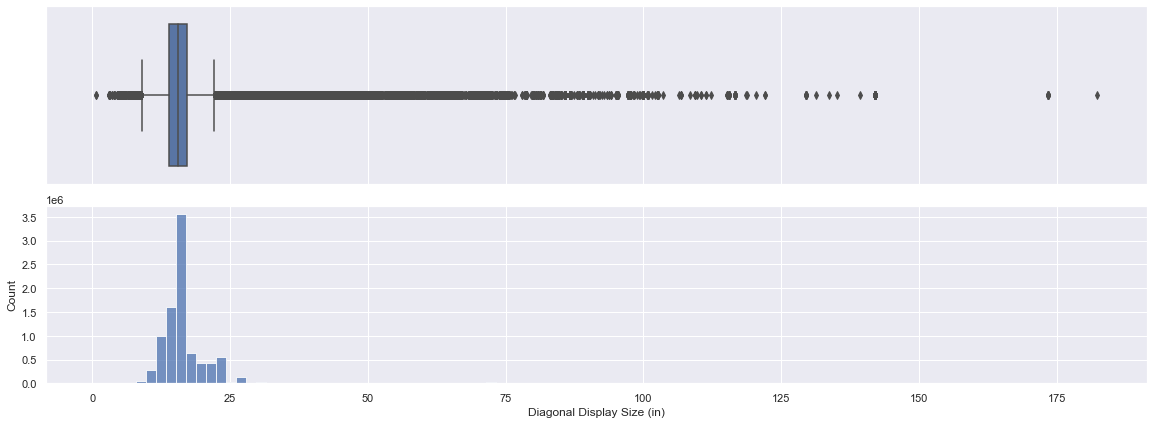

In [9]:
cont_var_subplots('Census_InternalPrimaryDiagonalDisplaySizeInInches', df, 'Diagonal Display Size (in)')

Outlier will be removed based on Z-score.

In [10]:
outlier_list = ['Census_InternalPrimaryDiagonalDisplaySizeInInches']

**Census_ProcessorCoreCount**

In [11]:
df['Census_ProcessorCoreCount'].nunique()

45

In [12]:
CoreCount_prob = pd.DataFrame(df['Census_ProcessorCoreCount'].value_counts(normalize=True)).reset_index()    
CoreCount_prob.columns = ['Core', 'Probability']
CoreCount_HasDetections_prob = df.groupby('Census_ProcessorCoreCount')['HasDetections'].mean().reset_index()
CoreCount_HasDetections_prob.columns = ['Core', 'HasDetections']
CoreCount_HasDetections_prob.head()

CoreCount_prob = CoreCount_prob.merge(CoreCount_HasDetections_prob,  
                     left_on='Core',
                     right_on='Core')
CoreCount_prob.Core = CoreCount_prob.Core.astype('int')

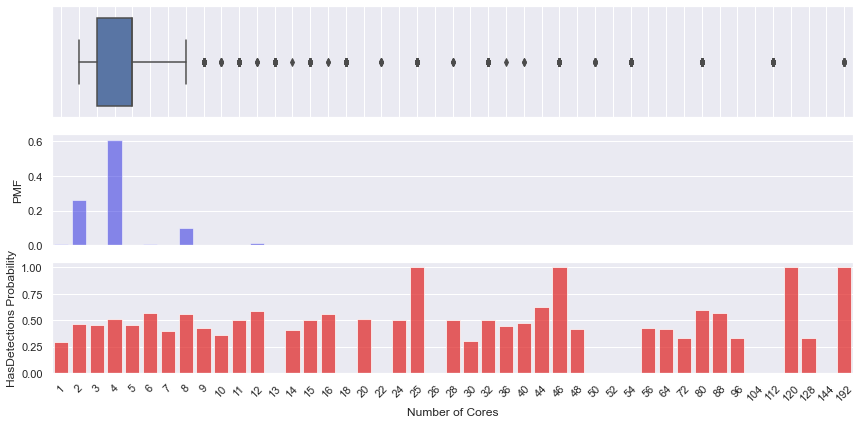

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

sns.boxplot(ax=axes[0],
             x='Census_ProcessorCoreCount', 
             data=df)
axes[0].set_xlabel('');

sns.barplot(ax=axes[1],
            x='Core', 
            y='Probability',
            data=CoreCount_prob,
            color='blue',
            alpha=0.5)
axes[1].set_xlabel('')
axes[1].set_ylabel('PMF')

sns.barplot(ax=axes[2],
            x='Core', 
            y='HasDetections',
            data=CoreCount_prob,
            color='red',
            alpha=0.7)
axes[2].set_xlabel('Number of Cores');
axes[2].set_ylabel('HasDetections Probability')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, horizontalalignment='center')
plt.tight_layout()

Very few machines have more than 8 cores, while the mode is 4. Extreme probabilities of detections are due to variability. I'll treat this as categorical and do roll up to reduce cardinality.

In [14]:
df['Census_ProcessorCoreCount'].nunique()

45

In [15]:
df['Census_ProcessorCoreCount'].value_counts().iloc[:20]

4.0     5430193
2.0     2311969
8.0      865004
12.0      92702
1.0       70390
6.0       69910
16.0      18551
3.0       13580
32.0       2136
24.0       1847
20.0       1781
40.0        506
36.0        287
28.0        271
48.0        235
5.0         216
56.0        132
10.0         98
64.0         93
7.0          92
Name: Census_ProcessorCoreCount, dtype: int64

In [16]:
df.loc[(df['Census_ProcessorCoreCount'] != 4) &
       (df['Census_ProcessorCoreCount'] != 2) &
       (df['Census_ProcessorCoreCount'] != 8) &
       (df['Census_ProcessorCoreCount'] != 12) & 
       (df['Census_ProcessorCoreCount'] != 1) &
       (df['Census_ProcessorCoreCount'] != 6) &
       (df['Census_ProcessorCoreCount'] != 16), 
       'Census_ProcessorCoreCount'] = 'Other'

In [17]:
df['Census_ProcessorCoreCount'].value_counts()

4.0      5430193
2.0      2311969
8.0       865004
12.0       92702
1.0        70390
6.0        69910
Other      62764
16.0       18551
Name: Census_ProcessorCoreCount, dtype: int64

In [18]:
df['Census_ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].astype('category')

**Census_PrimaryDiskTotalCapacity**

In [19]:
df.Census_PrimaryDiskTotalCapacity.nunique()

5707

In [20]:
df.Census_PrimaryDiskTotalCapacity.value_counts().iloc[:30]

476940.0     2841530
953869.0     2175780
305245.0      474616
122104.0      469060
244198.0      452284
238475.0      312093
29820.0       303493
114473.0      259542
715404.0      245946
228936.0      159491
152627.0      117362
1907729.0      98160
488386.0       96985
59640.0        95669
29824.0        88731
610480.0       84850
29600.0        43855
76319.0        27882
457862.0       25321
59648.0        21240
119276.0       19967
114480.0       18888
61057.0        18379
239372.0       16983
29184.0        16183
476938.0       15611
228944.0       15259
115712.0       14021
57241.0        12829
61440.0        12358
Name: Census_PrimaryDiskTotalCapacity, dtype: int64

I will treat this as a continuous variable.

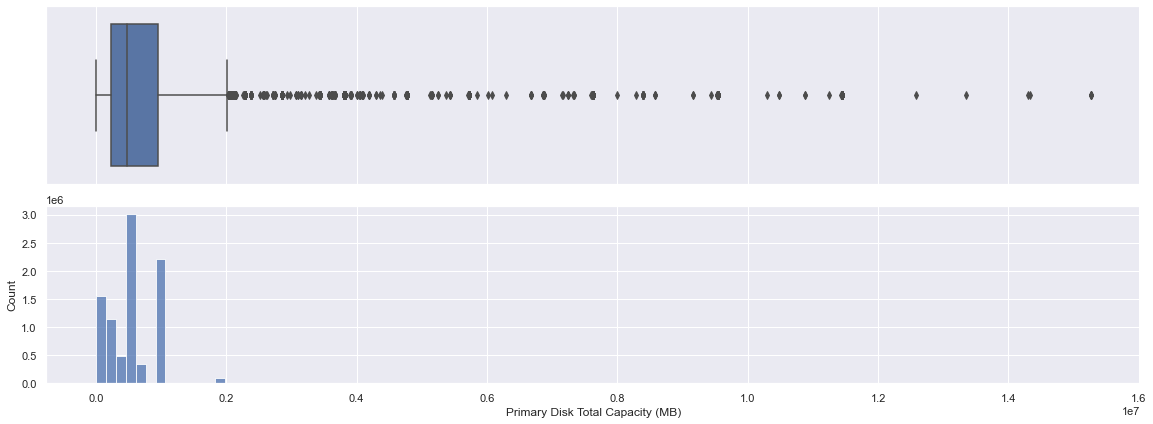

In [21]:
cont_var_subplots('Census_PrimaryDiskTotalCapacity', df, 'Primary Disk Total Capacity (MB)')

Outlier will be removed based on Z-score.

In [22]:
outlier_list.append('Census_PrimaryDiskTotalCapacity') 

**Census_SystemVolumeTotalCapacity**

In [23]:
df.Census_SystemVolumeTotalCapacity.nunique()

535313

In [24]:
df.Census_SystemVolumeTotalCapacity.value_counts().iloc[:30]

28542.0     51998
926992.0    50430
476389.0    44435
953253.0    41572
102400.0    41257
476324.0    40925
952728.0    38251
476323.0    35410
475799.0    33723
952727.0    33714
952792.0    32698
28558.0     31740
476438.0    30906
243582.0    28784
476373.0    27279
380772.0    26999
476388.0    26770
381546.0    26688
121488.0    26600
190001.0    26059
953318.0    25690
113922.0    25621
190774.0    25189
113857.0    23288
29043.0     23084
102401.0    21876
99500.0     21319
953093.0    21064
953302.0    20782
28557.0     20699
Name: Census_SystemVolumeTotalCapacity, dtype: int64

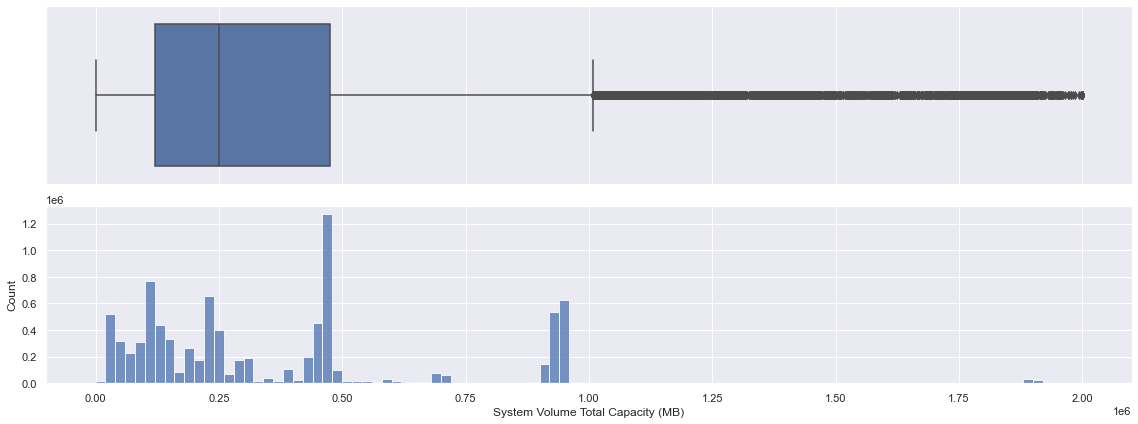

In [25]:
cont_var_subplots('Census_SystemVolumeTotalCapacity', df, 'System Volume Total Capacity (MB)')

I will treat this as a continuous variable.

Outlier will be removed based on Z-score.

In [26]:
outlier_list.append('Census_SystemVolumeTotalCapacity') 

**Census_TotalPhysicalRAM**

In [27]:
df.Census_TotalPhysicalRAM.nunique()

3446

In [28]:
df.Census_TotalPhysicalRAM.value_counts().iloc[:30]

4096.0      4094512
8192.0      2196505
2048.0      1097474
16384.0      531558
6144.0       398671
12288.0      159894
3072.0       152070
1024.0        66054
32768.0       58107
24576.0       11572
10240.0       10579
5120.0         7393
65536.0        6606
1536.0         4905
2560.0         4316
4095.0         4106
20480.0        3960
2047.0         3814
8191.0         1706
14336.0        1513
7168.0         1425
49152.0        1028
131072.0        936
3071.0          780
3584.0          714
18432.0         600
9216.0          551
6143.0          350
28672.0         317
3583.0          313
Name: Census_TotalPhysicalRAM, dtype: int64

I will treat this as a continuous variable.

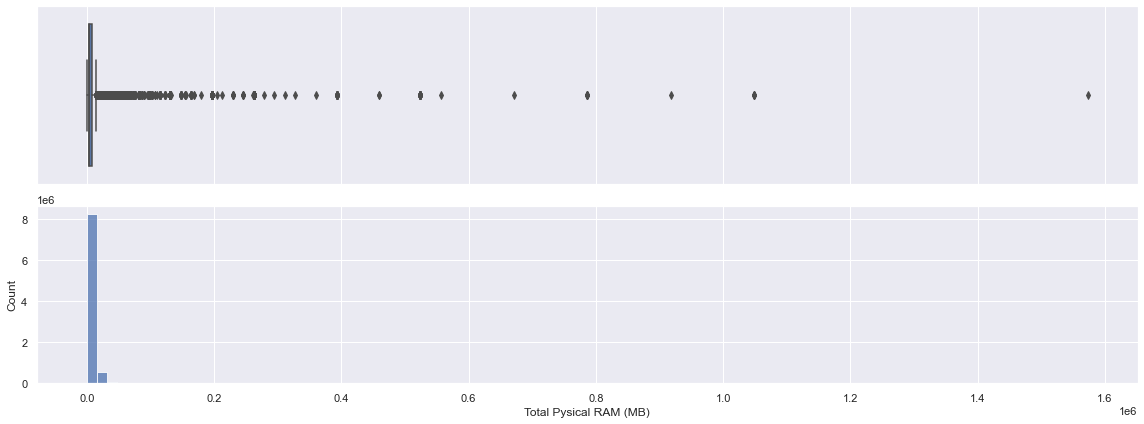

In [29]:
cont_var_subplots('Census_TotalPhysicalRAM', df, 'Total Pysical RAM (MB)')

<AxesSubplot:>

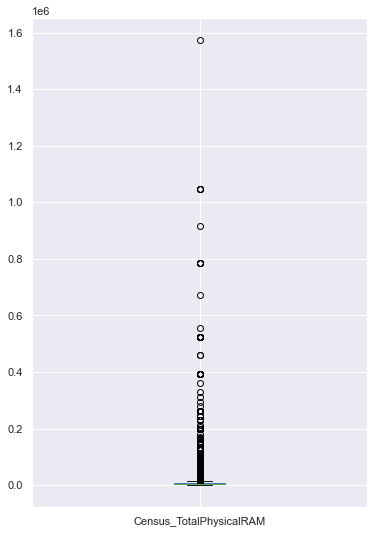

In [30]:
df['Census_TotalPhysicalRAM'].plot(kind='box', figsize=(6,9))

Outlier will be removed based on Z-score.

In [31]:
outlier_list.append('Census_TotalPhysicalRAM')

**Census_InternalPrimaryDisplayResolutionHorizontal**

In [32]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.nunique()

2179

In [33]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.value_counts().iloc[:30]

1366.0    4515064
1920.0    2220648
1280.0     527430
1600.0     501288
1024.0     342620
1440.0     167131
1360.0     128010
1680.0     109716
2560.0      70120
2736.0      57640
3840.0      44668
800.0       31940
2160.0      31667
3200.0      17335
3000.0      11071
2880.0      10107
640.0        8796
1368.0       8398
1152.0       7784
2256.0       5470
3440.0       5269
2048.0       5028
1400.0       4263
1200.0       3484
1080.0       3288
768.0        3159
1768.0       2004
2304.0       1969
4096.0       1930
1800.0       1777
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: int64

I will treat this as a continuous variable.

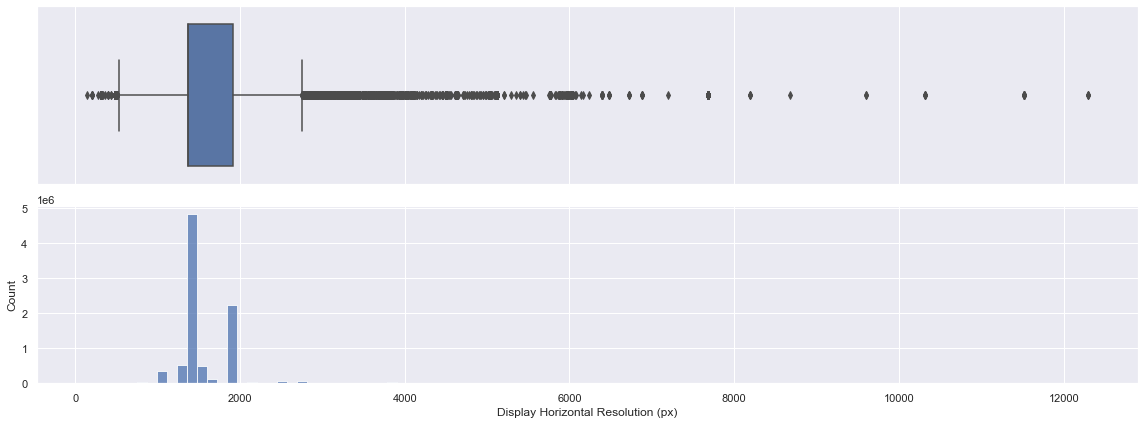

In [34]:
cont_var_subplots('Census_InternalPrimaryDisplayResolutionHorizontal', df, 'Display Horizontal Resolution (px)')

Outlier will be removed based on Z-score.

In [35]:
outlier_list.append('Census_InternalPrimaryDisplayResolutionHorizontal')

**Census_InternalPrimaryDisplayResolutionVertical**

In [36]:
df.Census_InternalPrimaryDisplayResolutionVertical.nunique()

1559

In [37]:
df.Census_InternalPrimaryDisplayResolutionVertical.value_counts().iloc[:30]

768.0     4973621
1080.0    2148402
900.0      655155
800.0      262058
1024.0     186322
1050.0     112220
1440.0      81251
1200.0      79397
600.0       63806
1824.0      57630
720.0       48483
2160.0      46777
1280.0      28870
1800.0      25532
1600.0      16009
2000.0      11066
480.0        8972
1920.0       8143
864.0        7550
960.0        6479
1504.0       5466
1152.0       2529
1536.0       2348
1366.0       2225
992.0        2018
1000.0       1641
2880.0       1588
945.0        1560
2736.0       1089
2100.0       1051
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: int64

I will treat this as a continuous variable.

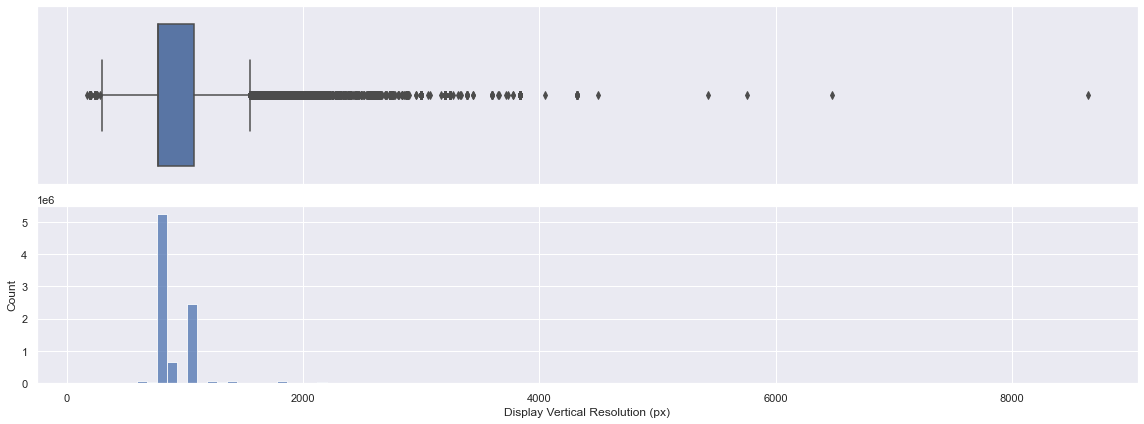

In [38]:
cont_var_subplots('Census_InternalPrimaryDisplayResolutionVertical', df, 'Display Vertical Resolution (px)')

Outlier will be removed based on Z-score.

In [39]:
outlier_list.append('Census_InternalPrimaryDisplayResolutionVertical')

**Census_InternalBatteryNumberOfCharges**

In [40]:
df.Census_InternalBatteryNumberOfCharges.nunique()

41087

In [41]:
df.Census_InternalBatteryNumberOfCharges.value_counts(normalize=True).iloc[:30]

0.000000e+00    0.584024
4.294967e+09    0.261651
1.000000e+00    0.006219
2.000000e+00    0.003251
1.600000e+01    0.003161
3.000000e+00    0.002489
3.300000e+01    0.002279
4.000000e+00    0.002083
5.000000e+00    0.001871
6.000000e+00    0.001673
7.000000e+00    0.001561
8.000000e+00    0.001501
9.000000e+00    0.001389
3.740000e+02    0.001344
1.000000e+01    0.001331
1.100000e+01    0.001281
4.380000e+02    0.001237
1.200000e+01    0.001221
1.300000e+01    0.001152
1.400000e+01    0.001133
3.770000e+02    0.001123
1.500000e+01    0.001112
2.560000e+02    0.001107
2.600000e+01    0.001068
1.700000e+01    0.001033
1.800000e+01    0.001019
3.840000e+02    0.001004
1.900000e+01    0.000979
2.000000e+01    0.000962
2.100000e+01    0.000947
Name: Census_InternalBatteryNumberOfCharges, dtype: float64

In [42]:
df.Census_InternalBatteryNumberOfCharges.max()

4294967300.0

<AxesSubplot:>

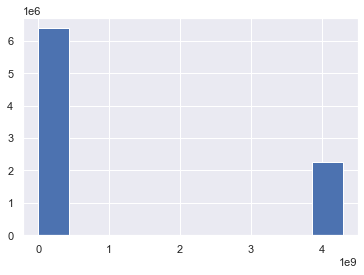

In [43]:
df.Census_InternalBatteryNumberOfCharges.hist()

In [44]:
int_battery_charge_contingency = pd.crosstab(df.Census_InternalBatteryNumberOfCharges, df.HasDetections)
int_battery_charge_contingency

HasDetections,0,1
Census_InternalBatteryNumberOfCharges,,
0.000000e+00,2541587,2511817
1.000000e+00,31203,22607
2.000000e+00,16455,11673
3.000000e+00,12580,8957
4.000000e+00,10615,7405
...,...,...
6.550900e+04,1,0
6.551600e+04,1,0
6.551900e+04,1,0


This might mean som values are missing (0's), others are actual values - even though small numbers like 1, 2, 3 .., and it seems caped to the max value of 4.3e9.

In [45]:
df.loc[df.Census_InternalBatteryNumberOfCharges == 0, 'Census_InternalBatteryNumberOfCharges'] = 0
df.loc[(df.Census_InternalBatteryNumberOfCharges != 0) &
       (df.Census_InternalBatteryNumberOfCharges != df.Census_InternalBatteryNumberOfCharges.max()), 
       'Census_InternalBatteryNumberOfCharges'] = 'Other'
df.Census_InternalBatteryNumberOfCharges = df.Census_InternalBatteryNumberOfCharges.map({0.0:'None',
                                                                                        4294967296.0: 'Max',
                                                                                        'Other':'Other'}).astype('category')
df.Census_InternalBatteryNumberOfCharges.value_counts()

None     5053404
Max      2263993
Other    1604086
Name: Census_InternalBatteryNumberOfCharges, dtype: int64

In [46]:
battery_charge_contingency = pd.crosstab(df.Census_InternalBatteryNumberOfCharges, df.HasDetections)
battery_charge_contingency

HasDetections,0,1
Census_InternalBatteryNumberOfCharges,,
Max,1096688,1167305
None,2541587,2511817
Other,824316,779770


In [47]:
chi2_contingency(battery_charge_contingency)

(3613.54117241781,
 0.0,
 2,
 array([[1132465.84518101, 1131527.15481899],
        [2527749.61402314, 2525654.38597686],
        [ 802375.54079585,  801710.45920415]]))

## Remove outliers

In [48]:
outlier_list

['Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical']

In [49]:
z_score = np.abs(stats.zscore(df[outlier_list], nan_policy='omit'))
z_score

array([[0.37736872, 0.10109194, 0.2405385 , 0.39471024, 0.29252398,
        0.0112461 ],
       [0.4711053 , 0.10109194, 0.8587275 , 0.39471024, 0.4934376 ,
        0.60387266],
       [0.81857526, 1.117893  , 0.8225834 , 0.39471024, 1.0106995 ,
        0.85004437],
       ...,
       [0.19959356, 0.7539853 , 0.41765776, 0.4059436 , 1.0106995 ,
        0.85004437],
       [0.67473906, 0.10109194, 0.27403343, 0.39471024, 1.4219843 ,
        0.60387266],
       [0.19959356, 1.2368006 , 0.81873906, 0.00561667, 1.0106995 ,
        0.85004437]], dtype=float32)

In [50]:
sum(z_score>3)/df.shape[0]*100

array([1.22248734, 1.23296766, 0.78336752, 0.90009699, 1.72831131,
       1.95568383])

In [51]:
outlier_indices = df[outlier_list][z_score > 3].index
outlier_indices

Int64Index([     18,      21,      34,      34,      35,      49,      63,
                 79,      79,      89,
            ...
            8921370, 8921400, 8921405, 8921405, 8921420, 8921425, 8921425,
            8921444, 8921444, 8921476],
           dtype='int64', length=697920)

In [104]:
clean_df = df.iloc[~df.index.isin(outlier_indices), :]
clean_df.shape

(8475427, 72)

In [105]:
cat_col = clean_df.select_dtypes('category').columns.tolist()
binary_col = clean_df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in clean_df.columns 
           if col not in cat_col
           if col not in binary_col]

**Multivariate Analysis**

In [54]:
num_col + binary_col

['Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

In [55]:
num_col_name_dict = {'Census_PrimaryDiskTotalCapacity':'Disk Capacity (MB)',
                     'Census_SystemVolumeTotalCapacity':'System Capacity (MB)',
                     'Census_TotalPhysicalRAM': 'RAM (MB)',
                     'Census_InternalPrimaryDiagonalDisplaySizeInInches':'Display Size (in)',
                     'Census_InternalPrimaryDisplayResolutionHorizontal':'Horizontal Resolution (px)',
                     'Census_InternalPrimaryDisplayResolutionVertical':'Vertical Resolution (px)',
                     }
bin_col_name_dict = {'IsSxsPassiveMode':'Passive Mode',
                     'HasTpm':'Tpm',
                     'AutoSampleOptIn':'Auto Sample',
                     'SMode':'SMode',
                     'Firewall':'Firewall',
                     'Census_HasOpticalDiskDrive':'Optical Disk Drive',
                     'Census_IsPortableOperatingSystem':'Portable OS',
                     'Census_IsFlightsDisabled':'Flights Disabled',
                     'Census_IsSecureBootEnabled':'Secure Boot',
                     'Census_IsVirtualDevice':'Virtual Device',
                     'Census_IsTouchEnabled':'Touch Enabled',
                     'Census_IsPenCapable':'Pen Capable',
                     'Census_IsAlwaysOnAlwaysConnectedCapable':'Always Connected Capable',
                     'Wdft_IsGamer':'Gamer',
                     'HasDetections':'HasDetections',
                     'IsProtected_encoded':'Protected'}

<Figure size 1080x1080 with 0 Axes>

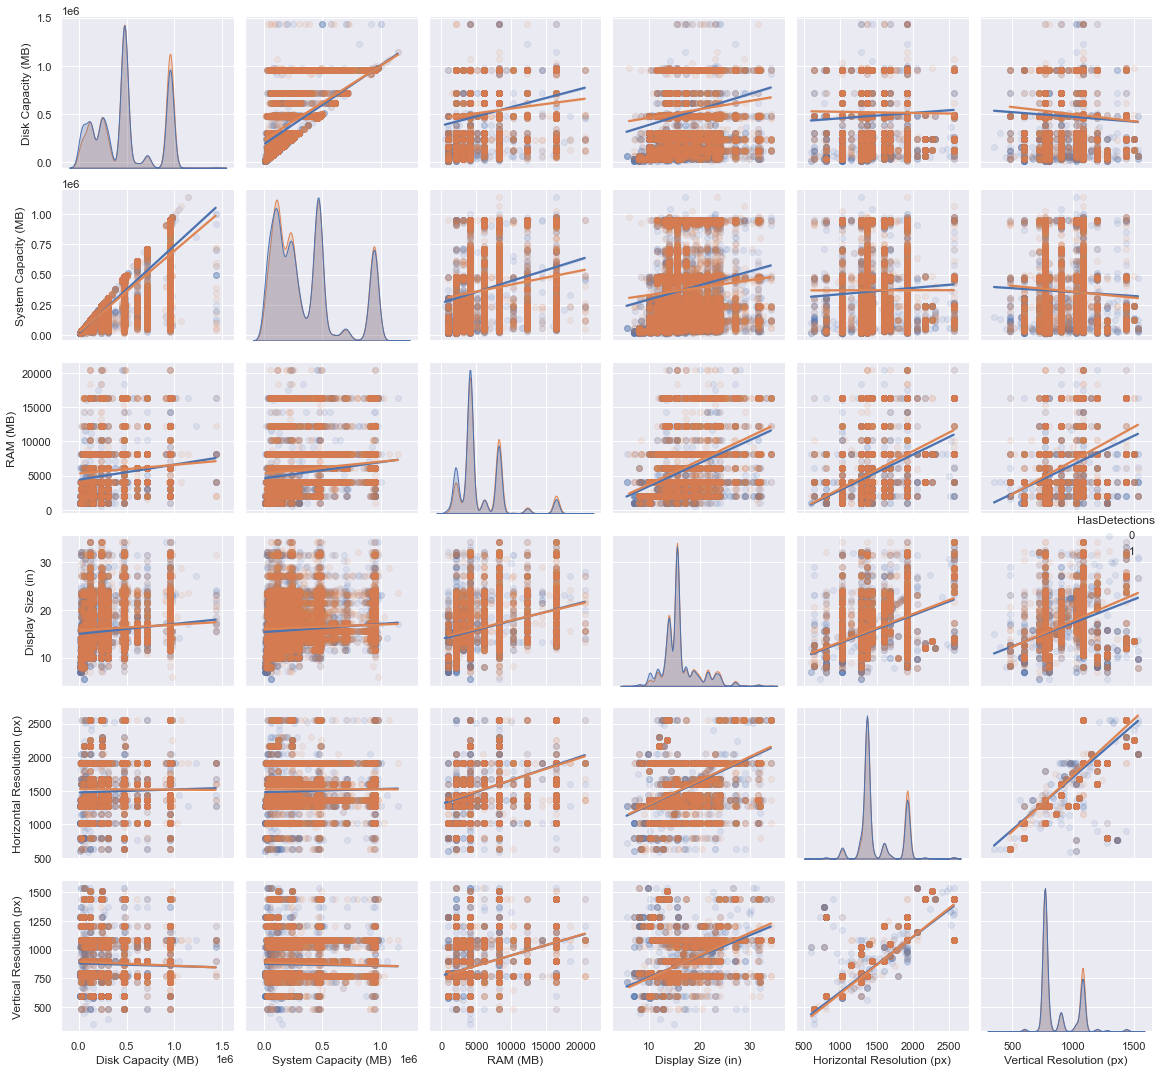

In [56]:
df_sample = clean_df[num_col+['HasDetections']].rename(columns=num_col_name_dict).sample(frac=0.01)
plt.figure(figsize=(15,15))
sns.pairplot(df_sample, hue='HasDetections', kind='reg', plot_kws={ 'scatter_kws': {'alpha': 0.1}})
plt.subplots_adjust(hspace=.2, wspace=.2)
plt.tight_layout();

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\scipy\interpolate\interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\scipy\interpolate\interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


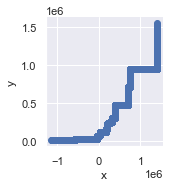

In [57]:
m = df['Census_PrimaryDiskTotalCapacity'].mean()
s = df['Census_PrimaryDiskTotalCapacity'].std()
x = np.random.normal(m, s, clean_df.shape[0])
y = clean_df['Census_PrimaryDiskTotalCapacity']
data = pd.DataFrame({'x':x, 'y':y})
from seaborn_qqplot import pplot
pplot(x='x', y='y', data=data, kind='qq');

<AxesSubplot:>

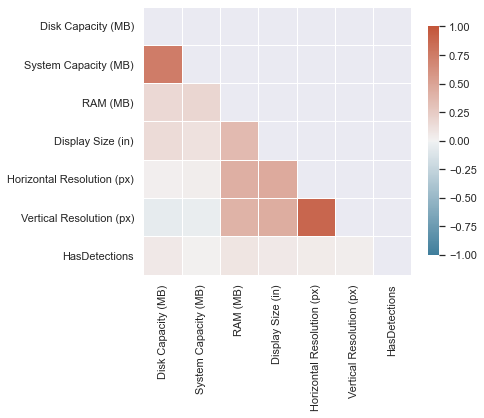

In [58]:
corr_matrix = clean_df[num_col+['HasDetections']].rename(columns=num_col_name_dict).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

<AxesSubplot:>

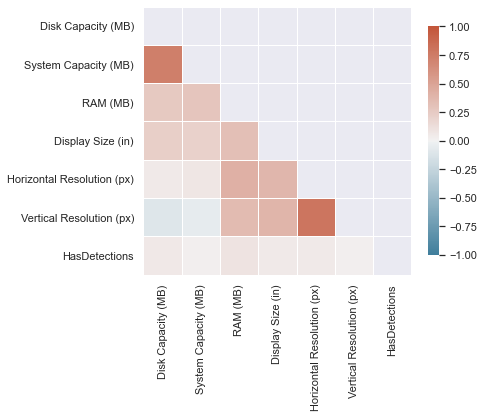

In [59]:
corr_matrix = clean_df[num_col+['HasDetections']].rename(columns=num_col_name_dict).corr('spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

As axpected the vertical and horizontal resolutions are correlated. Also the disk capacity and system capacity as one is a fraction of the other.

Relationship with target (boxplots and t-test)

Census_PrimaryDiskTotalCapacity Point biserial correlation coefficient: r=0.06, p-value=0.0.
Census_SystemVolumeTotalCapacity Point biserial correlation coefficient: r=0.01, p-value=0.0.
Census_TotalPhysicalRAM Point biserial correlation coefficient: r=0.08, p-value=0.0.
Census_InternalPrimaryDiagonalDisplaySizeInInches Point biserial correlation coefficient: r=0.06, p-value=0.0.
Census_InternalPrimaryDisplayResolutionHorizontal Point biserial correlation coefficient: r=0.04, p-value=0.0.
Census_InternalPrimaryDisplayResolutionVertical Point biserial correlation coefficient: r=0.03, p-value=0.0.


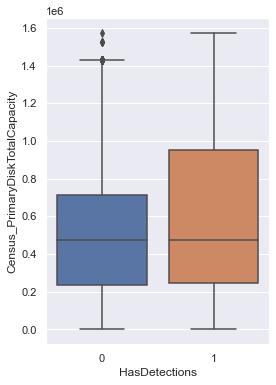

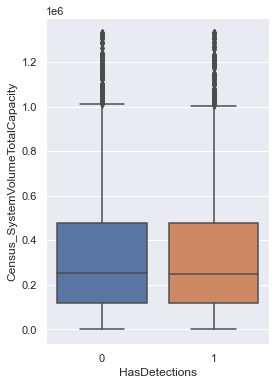

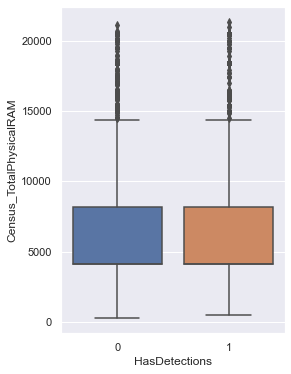

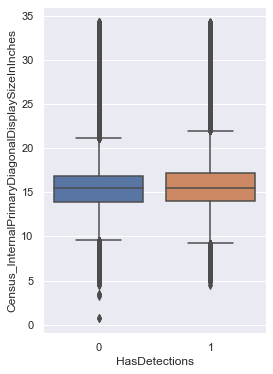

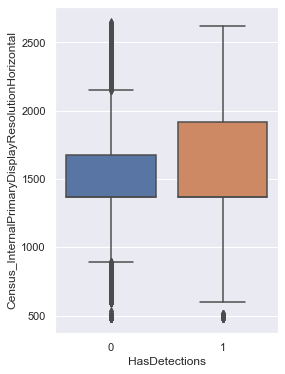

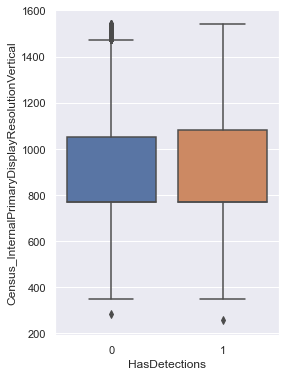

In [60]:
for col in num_col:
    plt.figure(figsize=(4,6))
    sns.boxplot(x='HasDetections', y=col, data=clean_df)
    r, pval = stats.pointbiserialr(clean_df[col].dropna(), clean_df.loc[clean_df[col].dropna().index, 'HasDetections'])
    print(f'{col} Point biserial correlation coefficient: r={round(r,2)}, p-value={pval}.')

In [61]:
#f_stat, p_val = f_classif(clean_df[num_col].dropna(), clean_df.loc[clean_df[num_col].dropna().index, 'HasDetections'])
#t_test = pd.DataFrame({'F-statistics':f_stat, 'p-value':p_val}, index=num_col)    
#t_test

### Binary features

In [62]:
binary_df = clean_df[binary_col].copy().astype('float')

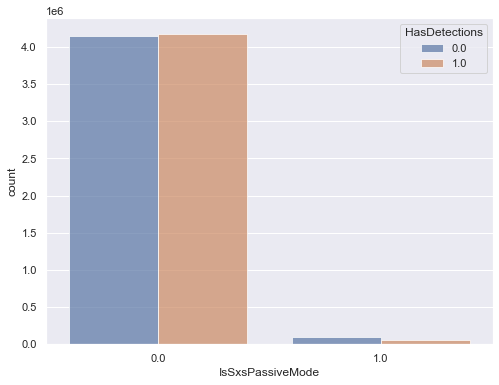

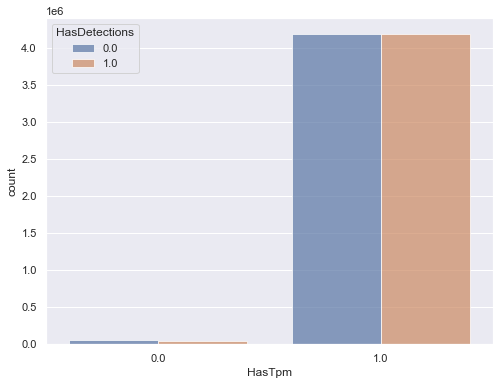

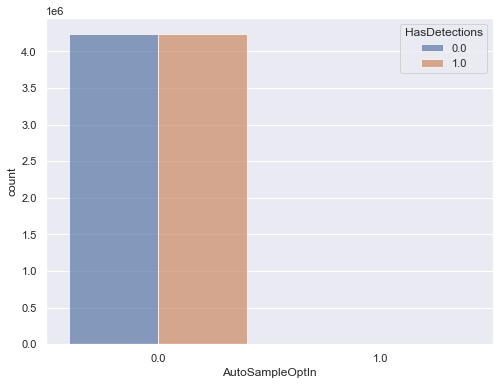

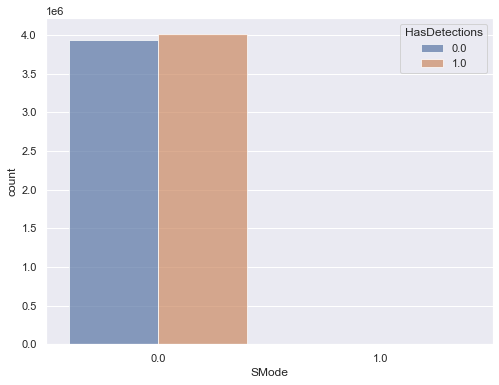

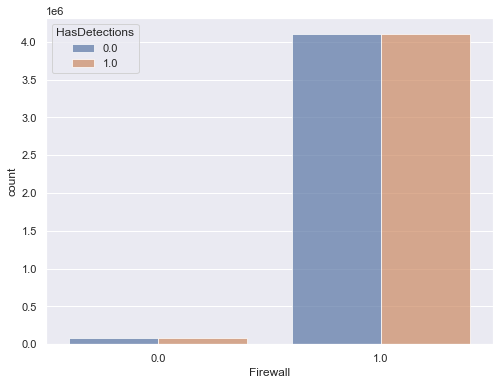

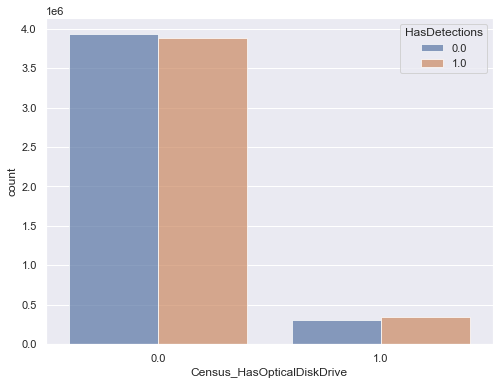

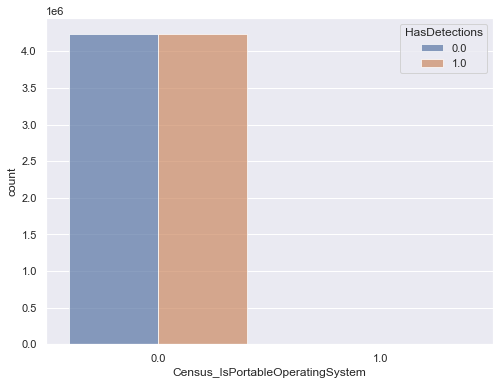

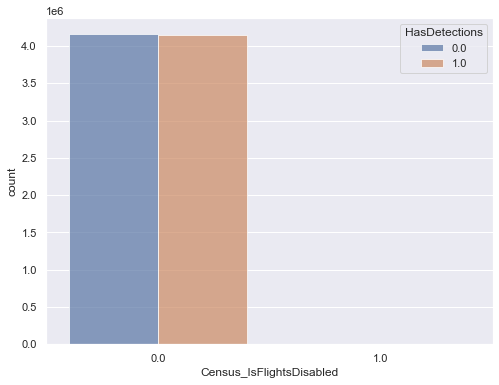

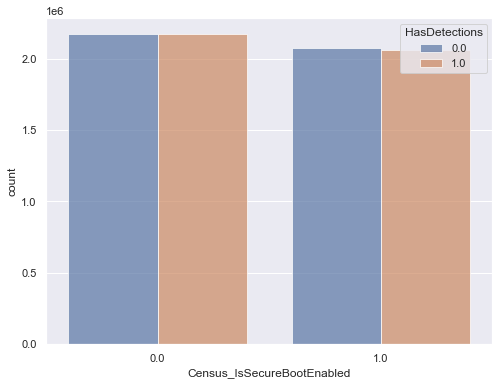

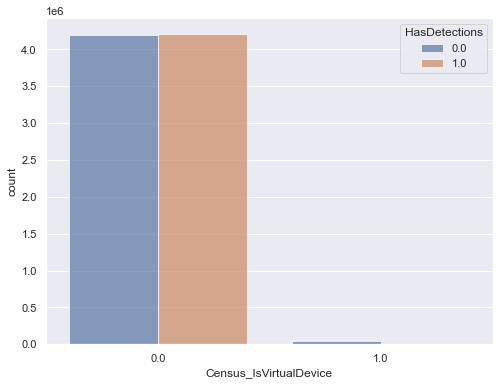

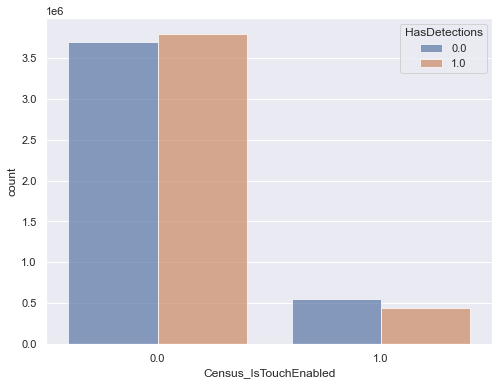

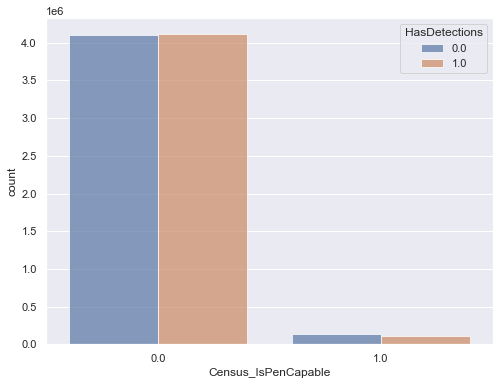

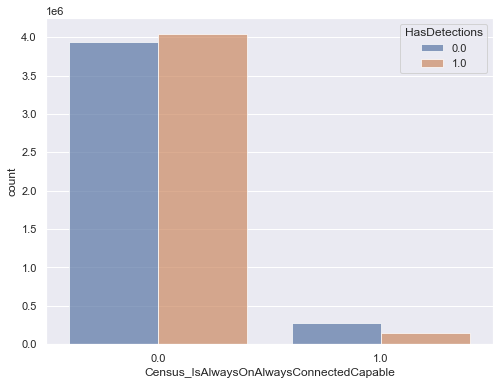

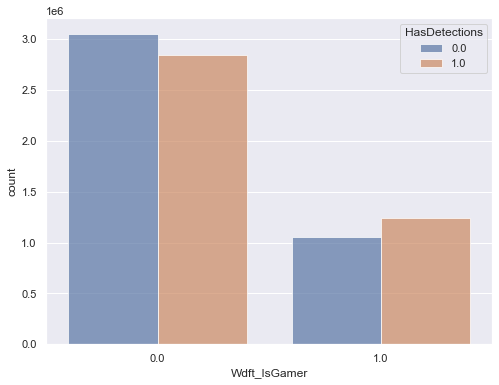

In [63]:
for col in binary_col:
    if col != 'HasDetections':
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, hue='HasDetections', data=binary_df, alpha=.7)

IsSxsPassiveMode, SMode, Census_IsTouchEnabled, Census_IsAlwaysOnAlwaysConnectedCapable, Wdft_IsGamer show less detections for the positive class. 'Census_HasOpticalDiskDrive' has more detections for the positive class. The other features' classes are equally distribited among detection and no detection.  

In [64]:
chi2_stat, p_val = chi2(clean_df[binary_col].dropna().astype('float'),
                        clean_df.loc[clean_df[binary_col].dropna().index, 'HasDetections'].astype('float'))
chi2_test = pd.DataFrame({'Chi2':chi2_stat, 'p-value':p_val}, index=binary_col)    
chi2_test.drop('HasDetections', axis=0).sort_values('Chi2', ascending=False)

,Chi2,p-value
Census_IsAlwaysOnAlwaysConnectedCapable,34346.308097,0.000000e+00
Census_IsVirtualDevice,21222.481820,0.000000e+00
Wdft_IsGamer,16983.581481,0.000000e+00
Census_IsTouchEnabled,12645.502641,0.000000e+00
IsSxsPassiveMode,10624.739785,0.000000e+00
Census_HasOpticalDiskDrive,3507.486295,0.000000e+00
Census_IsPenCapable,2701.779649,0.000000e+00
SMode,1700.387221,0.000000e+00
Census_IsSecureBootEnabled,112.025080,3.528186e-26
Census_IsPortableOperatingSystem,106.014905,7.318268e-25


## Categorical Features

In [106]:
cardinality = clean_df[cat_col].nunique().sort_values(ascending=False)
high_cardinality = cardinality[cardinality > 10].index
for col in high_cardinality:
    print(f'Feature: {col} \nUnique Values Count: {clean_df[col].nunique()}\n')   

Feature: Census_OEMModelIdentifier 
Unique Values Count: 169242

Feature: CityIdentifier 
Unique Values Count: 105706

Feature: Census_FirmwareVersionIdentifier 
Unique Values Count: 48764

Feature: AVProductStatesIdentifier 
Unique Values Count: 28305

Feature: Census_OEMNameIdentifier 
Unique Values Count: 3695

Feature: Census_ProcessorModelIdentifier 
Unique Values Count: 3322

Feature: Census_FirmwareManufacturerIdentifier 
Unique Values Count: 681

Feature: IeVerIdentifier 
Unique Values Count: 297

Feature: GeoNameIdentifier 
Unique Values Count: 291

Feature: Census_OSBuildRevision 
Unique Values Count: 281

Feature: LocaleEnglishNameIdentifier 
Unique Values Count: 252

Feature: CountryIdentifier 
Unique Values Count: 222

Feature: Census_OSUILocaleIdentifier 
Unique Values Count: 146

Feature: OsBuild 
Unique Values Count: 73

Feature: EngineVersion_extracted 
Unique Values Count: 63

Feature: AvSigVersion_extracted 
Unique Values Count: 51

Feature: Census_ChassisTypeName 
U

In [107]:
id_col = [col for col in cat_col if 'Identifier' in col]
id_col

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

These columns will be encoded with target encoding (mean encoding).
Let's implement roll-up on the others.

In [108]:
mean_encoding_list = id_col

In [109]:
[col for col in cat_col if 'Identifier' not in col if clean_df[col].nunique()>10]

['OsBuild',
 'OsSuite',
 'SmartScreen',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_ChassisTypeName',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSSkuName',
 'AvSigVersion_extracted',
 'AppVersion_extracted',
 'EngineVersion_extracted']

**OsBuild**

In [110]:
os_build = pd.concat([clean_df['OsBuild'].value_counts(), 
                      clean_df['OsBuild'].value_counts(normalize=True)*100], 
                      axis=1)
os_build.columns=['Count', '%']
os_build.head(10)

,Count,%
17134,3647308,43.033914
16299,2404784,28.373603
15063,750232,8.851849
14393,706683,8.338022
10586,402597,4.750168
10240,264422,3.119866
9600,189387,2.234542
7601,91115,1.075049
17692,2862,0.033768
17738,2143,0.025285


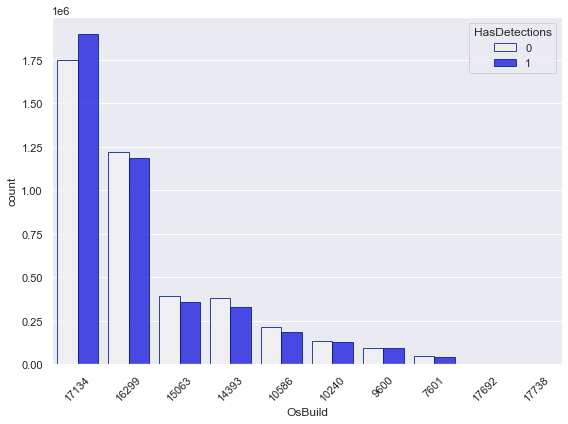

In [111]:
plt.figure(figsize=(8, 6))
sns.countplot(x='OsBuild',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['OsBuild'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [112]:
clean_df['OsBuild'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['OsBuild'] != 17134) & 
             (clean_df['OsBuild'] != 16299) &
             (clean_df['OsBuild'] != 15063) &
             (clean_df['OsBuild'] != 14393) &
             (clean_df['OsBuild'] != 10586) &
             (clean_df['OsBuild'] != 10240) &
             (clean_df['OsBuild'] != 9600) &
             (clean_df['OsBuild'] != 7601),
             'OsBuild'] = 'Other'
clean_df['OsBuild'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'OsBuild':'OsBuild_encoded'}, inplace=True)
clean_df['OsBuild_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

17134    0.430339
16299    0.283736
15063    0.088518
14393    0.083380
10586    0.047502
10240    0.031199
9600     0.022345
7601     0.010750
Other    0.002230
Name: OsBuild_encoded, dtype: float64

**OsSuite**

In [113]:
os_suite = pd.concat([clean_df['OsSuite'].value_counts(), 
                      clean_df['OsSuite'].value_counts(normalize=True)*100], 
                      axis=1)
os_suite.columns=['Count', '%']
os_suite.head(10)

,Count,%
768,5369403,63.352596
256,3095999,36.529121
272,8273,0.097612
400,556,0.006560
305,487,0.005746
16,455,0.005368
784,185,0.002183
274,26,0.000307
144,24,0.000283
49,15,0.000177


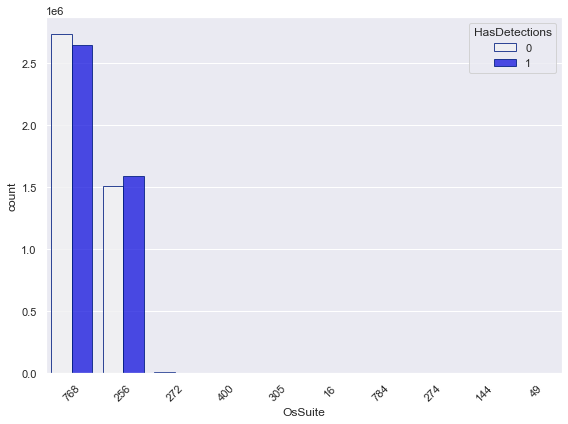

In [114]:
plt.figure(figsize=(8, 6))
sns.countplot(x='OsSuite',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['OsSuite'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [115]:
clean_df['OsSuite'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['OsSuite'] != 768) & 
             (clean_df['OsSuite'] != 256),
             'OsSuite'] = 'Other'
clean_df['OsSuite'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'OsSuite':'OsSuite_encoded'}, inplace=True)
clean_df['OsSuite_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

768      0.633526
256      0.365291
Other    0.001183
Name: OsSuite_encoded, dtype: float64

**SmartScreen**

In [116]:
smart_screen = pd.concat([clean_df['SmartScreen'].value_counts(), 
                          clean_df['SmartScreen'].value_counts(normalize=True)*100],
                         axis=1)
smart_screen.columns=['Count', '%']
smart_screen.head(15)

,Count,%
RequireAdmin,4150380,75.284208
ExistsNotSet,1009547,18.312286
Off,173489,3.146936
Warn,124858,2.264813
Prompt,31801,0.576842
Block,21321,0.386744
On,842,0.015273
&#x02;,392,0.007111
&#x01;,313,0.005678
0,3,0.000054


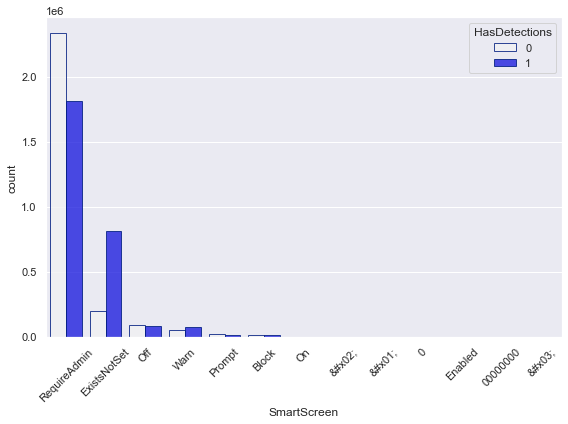

In [117]:
plt.figure(figsize=(8, 6))
sns.countplot(x='SmartScreen',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['SmartScreen'].value_counts().index,
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [118]:
clean_df['SmartScreen'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['SmartScreen'] == '&#x02;') | 
             (clean_df['SmartScreen'] == '&#x01;') |
             (clean_df['SmartScreen'] == '&#x03;') |
             (clean_df['SmartScreen'] == '0') |
             (clean_df['SmartScreen'] == 'Enabled') |
             (clean_df['SmartScreen'] == '00000000'),
             'SmartScreen'] = 'Other'
clean_df['SmartScreen'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'SmartScreen':'SmartScreen_encoded'}, inplace=True)
clean_df['SmartScreen_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

RequireAdmin    0.752842
ExistsNotSet    0.183123
Off             0.031469
Warn            0.022648
Prompt          0.005768
Block           0.003867
On              0.000153
Other           0.000129
Name: SmartScreen_encoded, dtype: float64

**UacLuaenable**

In [120]:
uac_luaenable = pd.concat([clean_df['UacLuaenable'].value_counts(), 
                          clean_df['UacLuaenable'].value_counts(normalize=True)*100],
                         axis=1)
uac_luaenable.columns=['Count', '%']
uac_luaenable.head(15)

,Count,%
1.0,8414329,99.401735
0.0,50373,0.595076
48.0,201,0.002374
2.0,29,0.000343
49.0,16,0.000189
6357062.0,13,0.000154
3.0,6,0.000071
5.0,2,0.000024
255.0,1,0.000012
7798884.0,1,0.000012


In [121]:
clean_df['UacLuaenable'].cat.add_categories('Other', inplace=True)
clean_df.loc[clean_df['UacLuaenable'] != 1, 'UacLuaenable'] = 'Other'
clean_df['UacLuaenable'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'UacLuaenable':'UacLuaenable_encoded'}, inplace=True)
clean_df['UacLuaenable_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

1.0      0.992791
Other    0.007209
Name: UacLuaenable_encoded, dtype: float64

**Census_MDC2FormFactor**

In [122]:
mdc2 = pd.concat([clean_df['Census_MDC2FormFactor'].value_counts(), 
                          clean_df['Census_MDC2FormFactor'].value_counts(normalize=True)*100],
                         axis=1)
mdc2.columns=['Count', '%']
mdc2.head(15)

,Count,%
Notebook,5594800,66.012013
Desktop,1746302,20.604295
Convertible,384793,4.540102
AllInOne,278160,3.281959
Detachable,236642,2.792095
PCOther,134696,1.589253
LargeTablet,61574,0.726500
SmallTablet,29788,0.351463
SmallServer,6269,0.073967
MediumServer,1660,0.019586


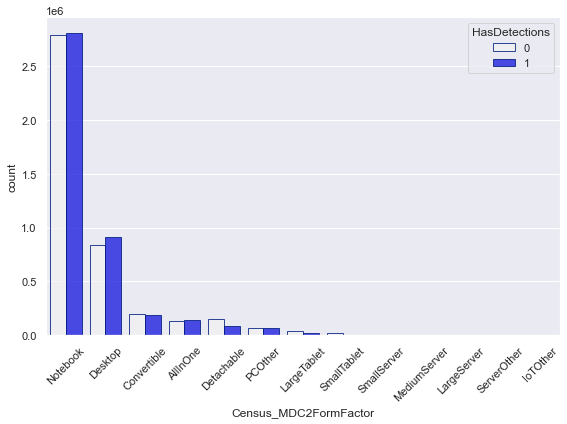

In [123]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Census_MDC2FormFactor',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_MDC2FormFactor'].value_counts().index,
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [124]:
clean_df['Census_MDC2FormFactor'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['Census_MDC2FormFactor'] == 'SmallServer') | 
             (clean_df['Census_MDC2FormFactor'] == 'MediumServer') |
             (clean_df['Census_MDC2FormFactor'] == 'LargeServer') |
             (clean_df['Census_MDC2FormFactor'] == 'ServerOther') |
             (clean_df['Census_MDC2FormFactor'] == 'IoTOther'),
             'Census_MDC2FormFactor'] = 'Other'
clean_df['Census_MDC2FormFactor'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_MDC2FormFactor':'Census_MDC2FormFactor_encoded'}, inplace=True)
clean_df['Census_MDC2FormFactor_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Notebook       0.660120
Desktop        0.206043
Convertible    0.045401
AllInOne       0.032820
Detachable     0.027921
PCOther        0.015893
LargeTablet    0.007265
SmallTablet    0.003515
Other          0.001023
Name: Census_MDC2FormFactor_encoded, dtype: float64

**Census_ChassisTypeName**

In [125]:
census_chassis = pd.concat([clean_df['Census_ChassisTypeName'].value_counts(),
                            clean_df['Census_ChassisTypeName'].value_counts(normalize=True)*100],
                            axis=1)
census_chassis.columns=['Count', '%']
census_chassis.head(10)

,Count,%
Notebook,5147806,60.742357
Desktop,1681282,19.838555
Laptop,579763,6.841006
Portable,356300,4.204219
AllinOne,193959,2.288650
MiniTower,79313,0.935866
Convertible,79000,0.932173
Other,72163,0.851499
UNKNOWN,64926,0.766105
Detachable,49880,0.588567


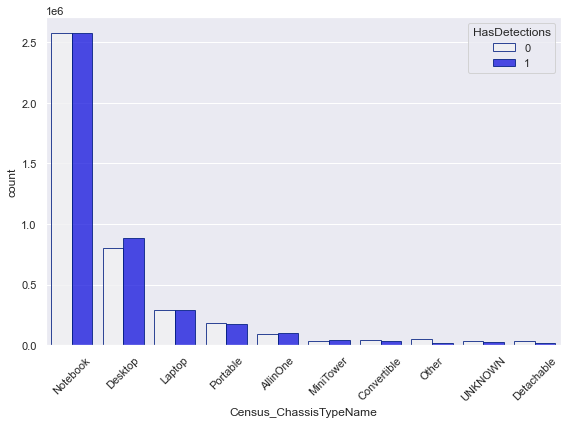

In [126]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Census_ChassisTypeName',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_ChassisTypeName'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [127]:
clean_df.loc[(clean_df['Census_ChassisTypeName'] != 'Notebook') &
             (clean_df['Census_ChassisTypeName'] != 'Desktop') &
             (clean_df['Census_ChassisTypeName'] != 'Laptop') &
             (clean_df['Census_ChassisTypeName'] != 'Portable') &
             (clean_df['Census_ChassisTypeName'] != 'AllinOne') &
             (clean_df['Census_ChassisTypeName'] != 'MiniTower') &
             (clean_df['Census_ChassisTypeName'] != 'Convertible'),
             'Census_ChassisTypeName'] = 'Other'
clean_df['Census_ChassisTypeName'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_ChassisTypeName':'Census_ChassisTypeName_encoded'}, inplace=True)
clean_df['Census_ChassisTypeName_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Notebook       0.607380
Desktop        0.198371
Laptop         0.068405
Other          0.042240
Portable       0.042039
AllinOne       0.022885
MiniTower      0.009358
Convertible    0.009321
Name: Census_ChassisTypeName_encoded, dtype: float64

**Census_OSBuildRevision**

In [128]:
census_os_build_rev = pd.concat([clean_df['Census_OSBuildRevision'].value_counts(),
                                 clean_df['Census_OSBuildRevision'].value_counts(normalize=True)*100],
                                 axis=1)
census_os_build_rev.columns=['Count', '%']
census_os_build_rev.head(30)

,Count,%
228,1316572,15.533990
165,840129,9.912527
431,530859,6.263507
285,437620,5.163398
547,332765,3.926233
112,327692,3.866377
371,311160,3.671319
2189,217255,2.563352
191,209306,2.469563
611,207206,2.444785


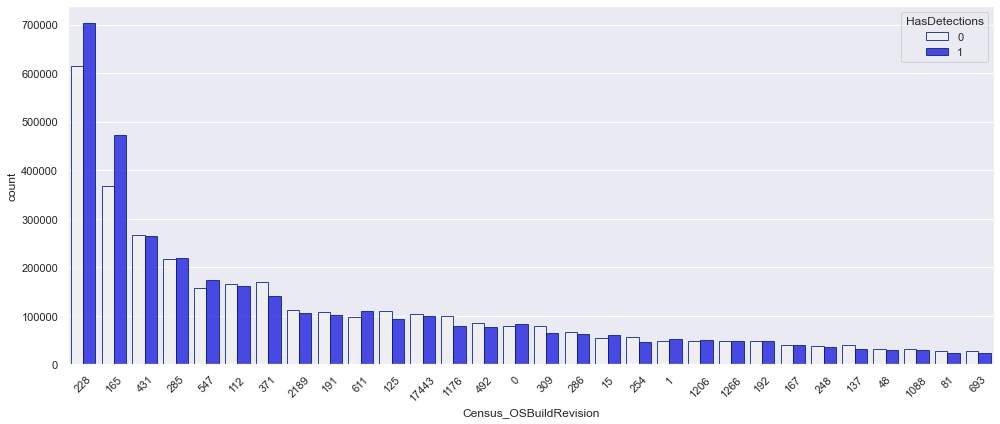

In [129]:
plt.figure(figsize=(14, 6))
sns.countplot(x='Census_OSBuildRevision',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_OSBuildRevision'].value_counts().index[:30],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [130]:
mean_encoding_list.append('Census_OSBuildRevision')

**Census_OSEdition**

In [131]:
census_os_edition = pd.concat([clean_df['Census_OSEdition'].value_counts(),
                               clean_df['Census_OSEdition'].value_counts(normalize=True)*100], 
                              axis=1)
census_os_edition.columns=['Count', '%']
census_os_edition.head(30)

,Count,%
Core,3321279,39.187158
Professional,2889618,34.094070
CoreSingleLanguage,1907465,22.505828
CoreCountrySpecific,161443,1.904836
ProfessionalEducation,56000,0.660734
Education,36808,0.434291
Enterprise,34662,0.408971
ProfessionalN,26507,0.312751
EnterpriseS,18734,0.221039
ServerStandard,6556,0.077353


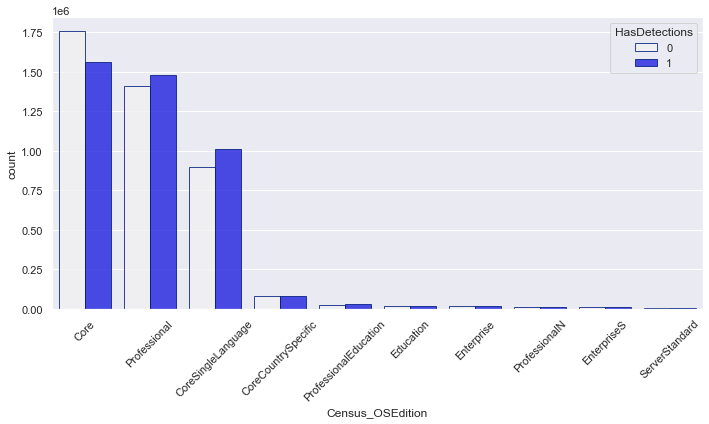

In [132]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Census_OSEdition',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_OSEdition'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [133]:
clean_df['Census_OSEdition'].cat.add_categories('Other', inplace=True)
other_os_edition = ~clean_df['Census_OSEdition'].isin(['Core',
                                                'Professional',
                                                'CoreSingleLanguage'])
clean_df.loc[other_os_edition, 'Census_OSEdition'] = 'Other'
clean_df['Census_OSEdition'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_OSEdition':'Census_OSEdition_encoded'}, inplace=True)
clean_df['Census_OSEdition_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Core                  0.391872
Professional          0.340941
CoreSingleLanguage    0.225058
Other                 0.042129
Name: Census_OSEdition_encoded, dtype: float64

**Census_OSSkuName**

In [135]:
census_os_sku = pd.concat([clean_df['Census_OSSkuName'].value_counts(),
                           clean_df['Census_OSSkuName'].value_counts(normalize=True)*100],
                           axis=1)
census_os_sku.columns=['Count', '%']
census_os_sku.head(30)

,Count,%
CORE,3321171,39.185884
PROFESSIONAL,2946218,34.761883
CORE_SINGLELANGUAGE,1907163,22.502264
CORE_COUNTRYSPECIFIC,161243,1.902476
EDUCATION,36922,0.435636
ENTERPRISE,34665,0.409006
PROFESSIONAL_N,26673,0.314710
ENTERPRISE_S,18736,0.221063
STANDARD_SERVER,6555,0.077341
CLOUD,6162,0.072704


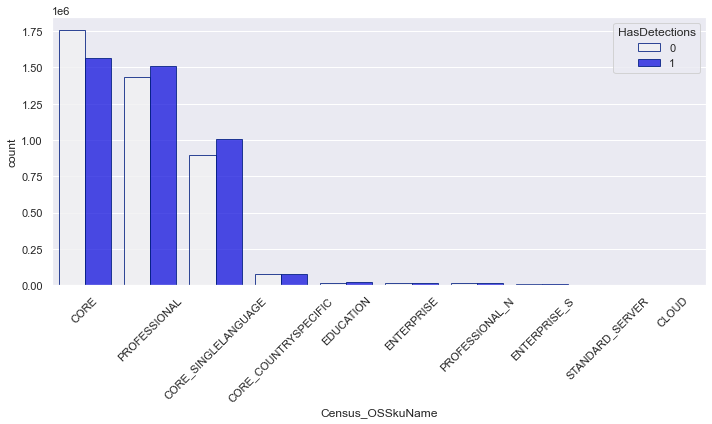

In [136]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Census_OSSkuName',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['Census_OSSkuName'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [137]:
clean_df['Census_OSSkuName'].cat.add_categories('Other', inplace=True)
clean_df.loc[(clean_df['Census_OSSkuName'] != 'CORE') & 
             (clean_df['Census_OSSkuName'] != 'PROFESSIONAL') &
             (clean_df['Census_OSSkuName'] != 'CORE_SINGLELANGUAGE') &
             (clean_df['Census_OSSkuName'] != 'CORE_COUNTRYSPECIFIC') &
             (clean_df['Census_OSSkuName'] != 'EDUCATION') &
             (clean_df['Census_OSSkuName'] != 'ENTERPRISE') &
             (clean_df['Census_OSSkuName'] != 'PROFESSIONAL_N') &
             (clean_df['Census_OSSkuName'] != 'PROFESSIONAL_S'),
             'Census_OSSkuName'] = 'Other'
clean_df['Census_OSSkuName'].cat.remove_unused_categories(inplace=True)
clean_df.rename(columns={'Census_OSSkuName':'Census_OSSkuName_encoded'}, inplace=True)
clean_df['Census_OSSkuName_encoded'].value_counts(normalize=True)

C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\marco\anaconda3\envs\capstone2env\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

CORE                    0.391859
PROFESSIONAL            0.347619
CORE_SINGLELANGUAGE     0.225023
CORE_COUNTRYSPECIFIC    0.019025
Other                   0.004881
EDUCATION               0.004356
ENTERPRISE              0.004090
PROFESSIONAL_N          0.003147
Name: Census_OSSkuName_encoded, dtype: float64

**AvSigVersion_extracted**

In [138]:
av_sig_ver = pd.concat([clean_df['AvSigVersion_extracted'].value_counts(),
                        clean_df['AvSigVersion_extracted'].value_counts(normalize=True)*100], 
                        axis=1)
av_sig_ver.columns=['Count', '%']
av_sig_ver.head(30)

,Count,%
275,3688184,43.516203
273,3533957,41.696507
271,261148,3.081237
269,208137,2.455770
263,153688,1.813336
267,135043,1.593347
251,90755,1.070802
277,75101,0.886103
237,67941,0.801623
261,47575,0.561329


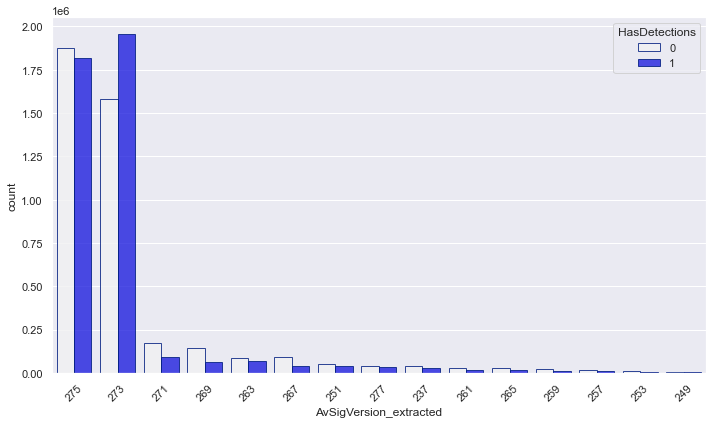

In [140]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AvSigVersion_extracted',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['AvSigVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

**AppVersion_extracted**

In [141]:
app_ver = pd.concat([clean_df['AppVersion_extracted'].value_counts(),
                        clean_df['AppVersion_extracted'].value_counts(normalize=True)*100], 
                        axis=1)
app_ver.columns=['Count', '%']
app_ver.head(30)

,Count,%
18,5660299,66.784824
12,534694,6.308756
13,491277,5.796487
10,445516,5.256561
9,407953,4.813362
8,269865,3.184087
14,238323,2.811929
16,225441,2.659937
11,197218,2.326939
5,2205,0.026016


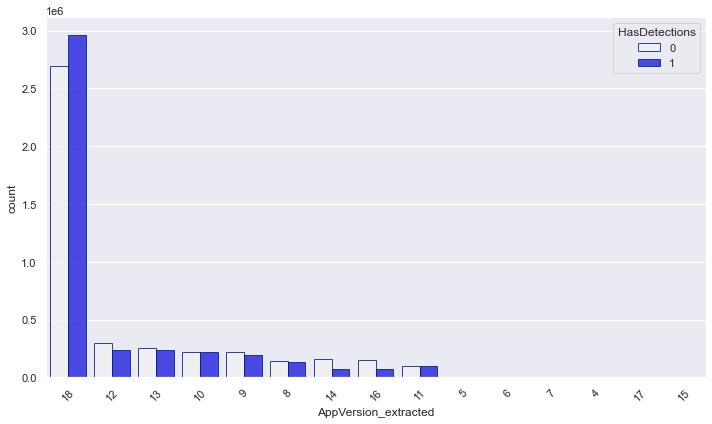

In [142]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AppVersion_extracted',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['AppVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

**EngineVersion_extracted**

In [143]:
eng_ver = pd.concat([clean_df['EngineVersion_extracted'].value_counts(),
                        clean_df['EngineVersion_extracted'].value_counts(normalize=True)*100], 
                        axis=1)
eng_ver.columns=['Count', '%']
eng_ver.head(30)

,Count,%
15200,3635726,42.897261
15100,3488643,41.161855
15000,259590,3.062855
14901,207691,2.450508
15300,177542,2.094785
14600,153618,1.812510
14800,133657,1.576994
14104,90505,1.067852
13504,67956,0.801800
14700,47955,0.565812


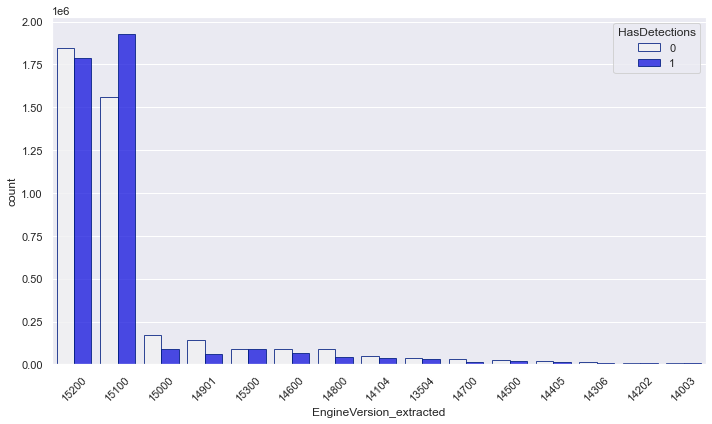

In [145]:
plt.figure(figsize=(10, 6))
sns.countplot(x='EngineVersion_extracted',
            hue='HasDetections',
            data=clean_df,
            order = clean_df['EngineVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

**'Census_OSBranch_release_extracted'**

In [97]:
census_os_release = pd.concat([clean_df['Census_OSBranch_release_extracted'].value_counts(),
                               clean_df['Census_OSBranch_release_extracted'].value_counts(normalize=True)*100],
                               axis=1)
census_os_release.columns=['Count', '%']
census_os_release.head(30)

,Count,%
rs4_release,3647295,43.033868
rs3_release_svc_escrow,1204897,14.216393
rs3_release,1146447,13.526750
rs2_release,750232,8.851871
rs1_release,519413,6.128473
th2_release_sec,273723,3.229615
th1,246589,2.909465
winblue_ltsb_escrow,133042,1.569742
th2_release,124379,1.467529
rs1_release_inmarket,104182,1.229227


In [101]:
clean_df['Census_OSBranch_release_extracted'] = clean_df['Census_OSBranch_release_extracted'].astype('object')
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs1', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs1_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs2', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs2_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs3', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs3_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs4', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs4_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs5', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs5_release'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('win', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'win'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('th2', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'th'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('th1', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'th'
clean_df.loc[clean_df['Census_OSBranch_release_extracted'].str.contains('rs_pre', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs_prerelease'

clean_df['Census_OSBranch_release_extracted'].value_counts(normalize=True)

<ipython-input-101-6e6645e0377f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Census_OSBranch_release_extracted'] = clean_df['Census_OSBranch_release_extracted'].astype('object')


rs4_release                  4.303387e-01
rs3_release                  2.837361e-01
rs2_release                  8.851871e-02
rs1_release                  8.338173e-02
th                           7.870054e-02
win                          3.316313e-02
rs5_release                  1.528894e-03
rs_prerelease                6.314742e-04
rs_onecore_sigma_grfx_dev    1.179884e-07
rs6_prerelease               1.179884e-07
rs_shell                     1.179884e-07
rs_onecore_base_cobalt       1.179884e-07
rs_xbox                      1.179884e-07
rs_onecore_stack_per1        1.179884e-07
Name: Census_OSBranch_release_extracted, dtype: float64

In [103]:
other_os_branch = ~clean_df['Census_OSBranch_release_extracted'].isin(['rs4_release',
                                                                       'rs3_release',
                                                                       'rs2_release',
                                                                       'rs1_release',
                                                                       'th'
                                                                       ])
clean_df.loc[other_os_branch, 'Census_OSBranch_release_extracted'] = 'Other'
clean_df['Census_OSBranch_release_extracted'] = clean_df['Census_OSBranch_release_extracted'].astype('category')
clean_df['Census_OSBranch_release_extracted'].value_counts(normalize=True)

<ipython-input-103-b1896c1eb7ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Census_OSBranch_release_extracted'] = clean_df['Census_OSBranch_release_extracted'].astype('category')


rs4_release    0.430338
rs3_release    0.283735
rs2_release    0.088518
rs1_release    0.083382
th             0.078700
Other          0.035327
Name: Census_OSBranch_release_extracted, dtype: float64

In [ ]:
sns.countplot(x='Census_ProcessorCoreCount',
            hue='HasDetections',
            data=df,
            color='blue',
            edgecolor=sns.color_palette("dark", 1),
            alpha=0.8)
plt.tight_layout()

Slightly more detections in machines with more cores, may this be because smaller computer are used for simpler tasks whereas computers with more cores are more engaged in risky activities (gaming, downloads, etc)?

In [ ]:
core_count_contingency = pd.crosstab(df['Census_ProcessorCoreCount'], df['HasDetections'])
core_count_contingency

In [ ]:
chi2, pval, dof, exp = chi2_contingency(core_count_contingency)
chi2, pval, dof, exp

In [ ]:
obs = core_count_contingency.values
obs

In [ ]:
diff =  np.square(exp-obs)/exp
sum(sum(diff))

**MultivariateAnalysis**

In [ ]:
# define function to create cdf dist plot
def cdf_dist_plots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='ecdf')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [ ]:
# define function to create kde dist plot
def kde_dist_plots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='kde')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [ ]:
cdf_dist_plots(numerical_columns, figsize=(15, 15))

In [ ]:
kde_dist_plots(rank_columns, figsize=(15, 15))

SmartScreen seems most predictive feature

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='IsProtected', hue='HasDetections', data=df, alpha=.7)
